# Homework #6
---
Student Name: Sam Crane

Student ID: 801101091

GitHub: https://github.com/samofuture/Intro-to-ML

In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.optim as optim
import torch.nn as nn
# use seaborn plotting defaults
import seaborn as sns; sns.set()
print(torch.cuda.device_count())
print(f"Version: {torch.__version__}, GPU: {torch.cuda.is_available()}, NUM_GPU: {torch.cuda.device_count()}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

1
Version: 2.1.1, GPU: True, NUM_GPU: 1


## Problem 1

In [8]:
def prep_data() -> pd.DataFrame:
    df = pd.read_csv("Housing.csv")
    furnish_encoder = LabelEncoder()
    df['mainroad'] = df['mainroad'].apply(lambda x: 1 if x == 'yes' else 0)
    df['guestroom'] = df['guestroom'].apply(lambda x: 1 if x == 'yes' else 0)
    df['basement'] = df['basement'].apply(lambda x: 1 if x == 'yes' else 0)
    df['hotwaterheating'] = df['hotwaterheating'].apply(lambda x: 1 if x == 'yes' else 0)
    df['airconditioning'] = df['airconditioning'].apply(lambda x: 1 if x == 'yes' else 0)
    df['prefarea'] = df['prefarea'].apply(lambda x: 1 if x == 'yes' else 0)
    # df['furnishingstatus'] = df['furnishingstatus'].apply(lambda x: 2 if x == 'furnished' else 0)
    df['furnishingstatus'] = furnish_encoder.fit_transform(df['furnishingstatus'])

    return df

In [9]:
df = prep_data()
price = df.pop('price').to_numpy()
df

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,1,0,0,0,1,2,1,0
1,8960,4,4,4,1,0,0,0,1,3,0,0
2,9960,3,2,2,1,0,1,0,0,2,1,1
3,7500,4,2,2,1,0,1,0,1,3,1,0
4,7420,4,1,2,1,1,1,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,1,0,1,0,0,2,0,2
541,2400,3,1,1,0,0,0,0,0,0,0,1
542,3620,2,1,1,1,0,0,0,0,0,0,2
543,2910,3,1,1,0,0,0,0,0,0,0,0


In [10]:
scaler_x = StandardScaler()
data = scaler_x.fit_transform(df)

scaler_y = StandardScaler()
price = scaler_y.fit_transform(price.reshape(-1, 1))

X_train, X_test, Y_train, Y_test = train_test_split(data, price, test_size=0.2, random_state=15)

train_inputs = torch.tensor(X_train).float()
train_outputs = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()
X_test = torch.tensor(X_test).float()

In [11]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [12]:
def training_loop(num_epochs, optimizer, model, t_in, t_out, v_in, v_out):
    for epoch in range(1, num_epochs+1):
        t_p = model(t_in)
        train_loss = loss_fn(t_p, t_out)
        v_p = model(v_in)
        val_loss = loss_fn(v_p, v_out)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}:")
            print(f"\tTraining Loss: {float(train_loss)}")
            print(f"\tValidation Loss: {float(val_loss)}")

    return model.parameters()

In [13]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

def training_loop_with_cv(num_epochs, optimizer, model, loss_fn, inputs, targets, num_folds=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(inputs, targets)):
        t_in, v_in = inputs[train_idx], inputs[val_idx]
        t_out, v_out = targets[train_idx], targets[val_idx]

        print(f"Training Fold {fold + 1}/{num_folds}:")

        for epoch in range(1, num_epochs + 1):
            # Training
            model.train()
            t_p = model(t_in)
            train_loss = loss_fn(t_p, t_out)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            v_p = model(v_in)
            val_loss = loss_fn(v_p, v_out)

            if epoch % 500 == 0:
                print(f"Epoch {epoch}:")
                print(f"\tTraining Loss: {float(train_loss)}")
                print(f"\tValidation Loss: {float(val_loss)}")

    return model

In [14]:
housing_model = nn.Sequential(
                nn.Linear(len(df.columns), 32),
                nn.ReLU(),
                nn.Linear(32, 1))
optimizer = optim.SGD(housing_model.parameters(), lr=0.001)

training_loop(5000, optimizer, housing_model, train_inputs, train_outputs, X_test, Y_test)

Epoch 500:
	Training Loss: 0.43353015184402466
	Validation Loss: 0.5522839426994324
Epoch 1000:
	Training Loss: 0.34394651651382446
	Validation Loss: 0.46478649973869324
Epoch 1500:
	Training Loss: 0.31984594464302063
	Validation Loss: 0.44427594542503357
Epoch 2000:
	Training Loss: 0.30723854899406433
	Validation Loss: 0.4347897171974182
Epoch 2500:
	Training Loss: 0.29896819591522217
	Validation Loss: 0.42940303683280945
Epoch 3000:
	Training Loss: 0.2929984927177429
	Validation Loss: 0.42578548192977905
Epoch 3500:
	Training Loss: 0.28828635811805725
	Validation Loss: 0.42303478717803955
Epoch 4000:
	Training Loss: 0.28439339995384216
	Validation Loss: 0.4209675192832947
Epoch 4500:
	Training Loss: 0.2810577154159546
	Validation Loss: 0.4191916286945343
Epoch 5000:
	Training Loss: 0.2779354453086853
	Validation Loss: 0.4173828959465027


<generator object Module.parameters at 0x0000023ED0791D20>

In [15]:
housing_model = nn.Sequential(
                nn.Linear(len(df.columns), 32),
                nn.ReLU(),
                nn.Linear(32, 1))
optimizer = optim.SGD(housing_model.parameters(), lr=0.001)

training_loop_with_cv(5000, optimizer, housing_model, loss_fn, train_inputs, train_outputs)

Training Fold 1/5:
Epoch 500:
	Training Loss: 0.4466761350631714
	Validation Loss: 0.44470709562301636
Epoch 1000:
	Training Loss: 0.34343641996383667
	Validation Loss: 0.33008602261543274
Epoch 1500:
	Training Loss: 0.31954967975616455
	Validation Loss: 0.3064955770969391
Epoch 2000:
	Training Loss: 0.3074979782104492
	Validation Loss: 0.2988772988319397
Epoch 2500:
	Training Loss: 0.2990087568759918
	Validation Loss: 0.29544419050216675
Epoch 3000:
	Training Loss: 0.2926625907421112
	Validation Loss: 0.2939257025718689
Epoch 3500:
	Training Loss: 0.2873786985874176
	Validation Loss: 0.2933778464794159
Epoch 4000:
	Training Loss: 0.28283005952835083
	Validation Loss: 0.2934132516384125
Epoch 4500:
	Training Loss: 0.2788689136505127
	Validation Loss: 0.2937256693840027
Epoch 5000:
	Training Loss: 0.27541428804397583
	Validation Loss: 0.29418814182281494
Training Fold 2/5:
Epoch 500:
	Training Loss: 0.2742505371570587
	Validation Loss: 0.28274160623550415
Epoch 1000:
	Training Loss: 0.2

Sequential(
  (0): Linear(in_features=12, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)

## Problem 2

In [2]:
from torchvision import datasets, transforms
data_path = 'data-unversioned/p1ch7'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

c:\Users\Sam\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Sam\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Files already downloaded and verified
Files already downloaded and verified


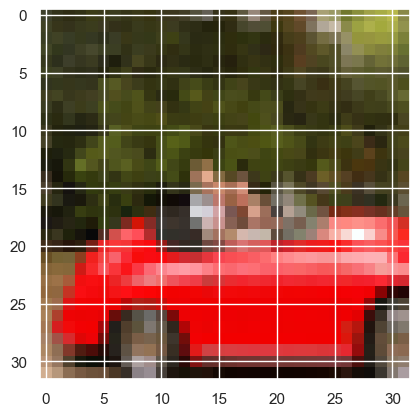

In [3]:
img, label = cifar10[99]
plt.imshow(img)
plt.show()

In [4]:
to_tensor = transforms.ToTensor()

cifar10_tensor = datasets.CIFAR10(data_path, train=True, download=False, transform=to_tensor)

imgs = torch.stack([img_t for img_t, _ in cifar10_tensor], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

# print("M", type(mean))
# print("S", std)
# transforms.Normalize(mean, std)


In [5]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

# cifar10 = [(img, label) for img, label in cifar10]

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

# cifar10_val = [(img, label) for img, label in cifar10_val]

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

n_out = 10

cifar_model = nn.Sequential(
                    nn.Linear(3072, 512),
                    # nn.ReLU(),
                    # nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Linear(512, n_out),
                    nn.Softmax(dim=1)
                )

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(cifar_model.parameters(), lr = 0.01)
num_epochs = 100

In [20]:
new_model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 10))

In [25]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [26]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True)

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-02 18:39:31.725474 Epoch 1, Training loss 2.0475708695933643
2023-12-02 18:42:43.357330 Epoch 10, Training loss 1.1856087433255238
2023-12-02 18:46:17.277680 Epoch 20, Training loss 1.0059958333554475
2023-12-02 18:49:52.609951 Epoch 30, Training loss 0.9336449801921844
2023-12-02 18:53:28.861767 Epoch 40, Training loss 0.8844456407420166
2023-12-02 18:57:01.941340 Epoch 50, Training loss 0.8441681743354139
